## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.backends.backend_pdf import PdfPages
import torch
import torch.nn.functional as F
import sys
import os
from torch.utils.data import DataLoader, random_split
import wandb
import random
import datetime

# 로컬 모듈 import로 변경
from models.resnet import *
from models.CenterSpeed import *
from dataset.CenterSpeed_dataset import *
from models.losses import *
from train import *


%env "WANDB_NOTEBOOK_NAME" "centerspeed.ipynb"
print(wandb.__version__)
wandb.login()

/home/harry/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.5.0) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.5.0) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


env: "WANDB_NOTEBOOK_NAME"="centerspeed.ipynb"
0.21.0


wandb: Currently logged in as: whdaudpark (whdaudpark-dongguk-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## Load Data

In [2]:
def cartesian_to_pixel(x, y, image_size=[64,64], pixel_size=0.1):
    pixel_x = int(x / pixel_size + image_size[0] / 2)
    pixel_y = int(y / pixel_size + image_size[1] / 2)
    return pixel_x, pixel_y

# torchvision transforms를 사용하도록 수정
from torchvision import transforms

# 데이터 증강 설정 (45도 회전 및 50% 확률로 좌우 반전) 근데 지금 None으로 설정 되어있음 
# transform = transforms.Compose([transforms.RandomRotation(45),
#                                 transforms.RandomHorizontalFlip(0.5)])

# 일단 transform을 None으로 설정 (사용자 정의 RandomRotation, RandomFlip이 없으므로)
transform = None

# 데이터셋 경로를 절대경로로 유지 (원본 데이터가 있는 곳)
set = CenterSpeedDataset('/home/harry/ros2_ws/src/TinyCenterSpeed/dataset/data/TinyCenterSpeed_dataset/data/CenterSpeedDataset', transform=transform, dense=True)
# 이 dataset 함수에서 반환하는 값이 input, gt_heatmap, data, dense_data, is_free 이렇게 5개임

set.seq_len = 2 # 2개의 프레임 입력
# 학습 시 스케일링 파라미터 설정 이게 heatmap 만들때 스케일 된 좌표를 사용하는건데 센서 데이터의 오차가 생길 수 있음을 고려해서 만든거지 
# 1.0이면 원본 크기, 0.9면 10% 축소
set.sx = 0.9
set.sy = 0.9
set.change_image_size(64)
set.change_pixel_size(0.1)

# Fixed: Use absolute path for validation_set.csv
# validation_set.csv 파일의 절대 경로를 사용하여 데이터셋을 로드
independent_test_set = LidarDatasetSeqOD('/home/harry/ros2_ws/src/TinyCenterSpeed/dataset/data/TinyCenterSpeed_dataset/data/validation_set.csv')
independent_test_set.seq_len = 2

# 

Reading the following files:  /home/harry/ros2_ws/src/TinyCenterSpeed/dataset/data/TinyCenterSpeed_dataset/data/CenterSpeedDataset/16_05_Dataset04.csv
Number of entries:  386
Reading the following files:  /home/harry/ros2_ws/src/TinyCenterSpeed/dataset/data/TinyCenterSpeed_dataset/data/CenterSpeedDataset/06_04_Dataset02.csv
Number of entries:  1278
Reading the following files:  /home/harry/ros2_ws/src/TinyCenterSpeed/dataset/data/TinyCenterSpeed_dataset/data/CenterSpeedDataset/25_04_Dataset03_10s.csv
Number of entries:  350
Number of rows:  2014
File indices:  [(0, 386), (386, 1664), (1664, 2014)]
Image size changed to:  64
Origin offset changed to:  2.56
Pixel size changed to:  0.1
Origin offset changed to:  3.2
Number of sets 0
Length of Dataset 1227
Dataset Setup!


Using dense features with data: tensor([ 0.6453,  0.2898,  1.2041, -1.4280,  0.8703])
Data length: 5
Data: GT


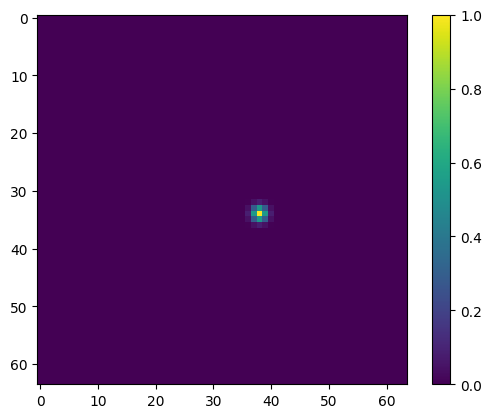

Dense data shape: torch.Size([64, 64, 3])

Data: VX
Maximum from data: 1.2040857076644897
Maximum value in image slice 0: 1.2040857076644897
Minimum value in image slice 0: 0.0


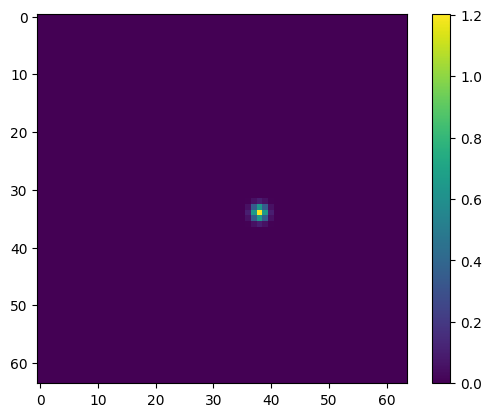

Data: VY
Maximum from data: -1.4280284643173218
Maximum value in image slice 1: -0.0
Minimum value in image slice 1: -1.4280284643173218


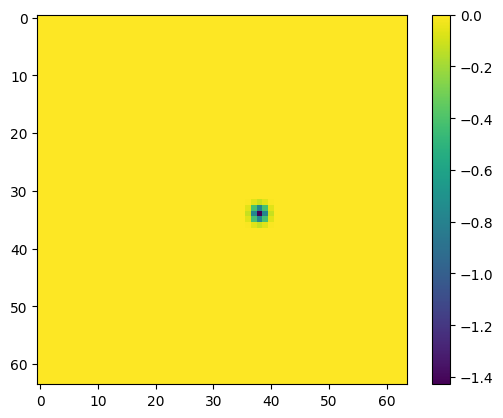

Data: YAW
Maximum from data: 0.8702746629714966
Maximum value in image slice 2: 0.8702746629714966
Minimum value in image slice 2: 0.0
Maximum value in image slice 2: 0.8702746629714966
Minimum value in image slice 2: 0.0


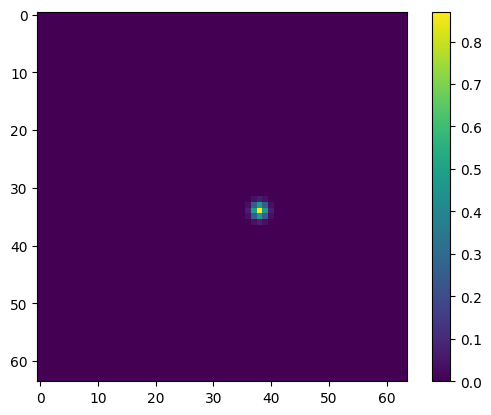

In [3]:
# 데이터셋에서 샘플 불러와서 데이터 구성 요소 시각화 

input, gt_heatmap, data, dense_data, is_free = set[1]  
# input은 (3, 64, 64) 형태로 되어있음
# gt_heatmap은 (64, 64) 형태로 되어있음
# data는 (x, y, yaw, vx, vy, yaw_rate) 형태로 되어있음
# dense_data는 (64, 64, 3) 형태로 되어있음
# is_free는 (1, 64, 64) 형태로 되어있음   0은 장애물, 1은 자유공간

print(f'Data: GT')
# plt.imshow(input[1].numpy(), cmap='gray')
plt.imshow(gt_heatmap)
plt.colorbar() #색상 스케일 바
plt.show()

labels = ['VX', 'VY', 'YAW']
print(f'Dense data shape: {dense_data.shape}\n')

for i in range(dense_data.shape[2]):
    plt.imshow(dense_data[:,:,i])
    print(f'Data: {labels[i]}')
    print(f'Maximum from data: {data[i+2].item()}')
    # Extract and print the maximum value
    max_value = np.max(dense_data[:,:,i].numpy().flatten())
    min_value = np.min(dense_data[:,:,i].numpy().flatten())
    print(f"Maximum value in image slice {i}: {max_value}")
    print(f"Minimum value in image slice {i}: {min_value}")
    plt.colorbar()
    plt.show()



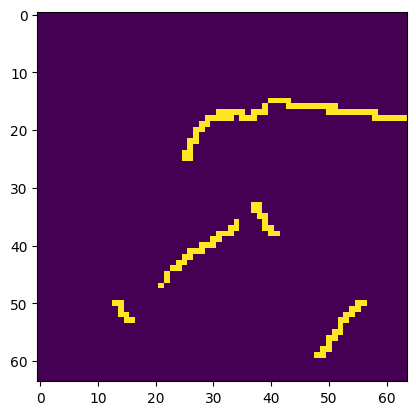

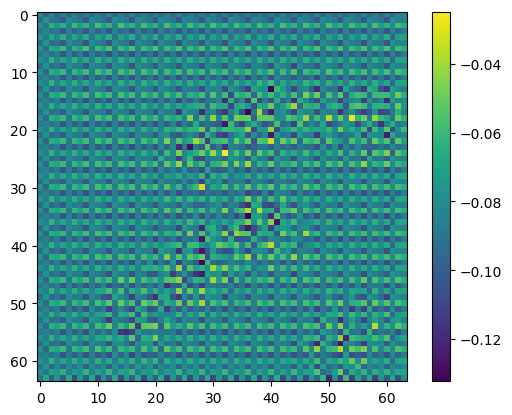

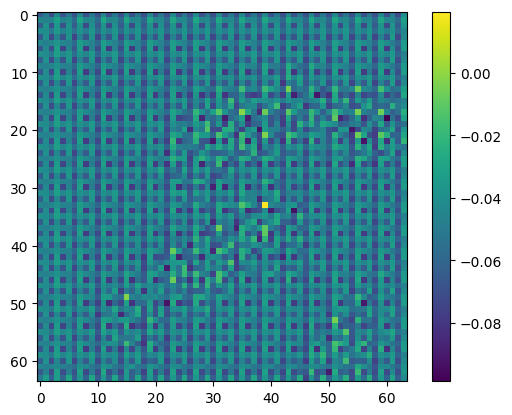

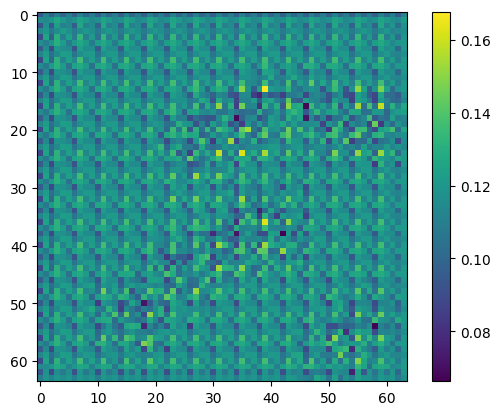

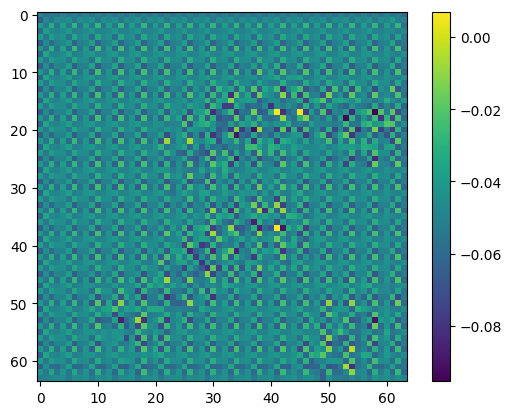

In [4]:
### TEST THE MODEL
# 학습 전 모델 테스트 -> 입출력 정상적으로 작동하는지 

model = CenterSpeedDense() # 모델 초기화, 가중치는 랜덤
model.eval() #평가 모드(드롭아웃(학습 할 때 뉴런 일부를 무작윙로 꺼버리는 법), 배치 정규화 비활성화)

output = model(input.unsqueeze(0)) #(6, 64, 64) → (1, 6, 64, 64) 배치 차원 추가 
#pytorch 모델의 입력은 항상 아래 형태를 기대함 
# B, C, H, W = 배치 크기. 체널수, 높이, 너비

plt.imshow(input[0])
plt.show()
for i in range(output.shape[1]): #output.shape[1]은 4임 (채널 수)
    plt.imshow(output[0,i].detach().numpy()) #detach : 그래디언트 분리
    plt.colorbar()
    plt.show()

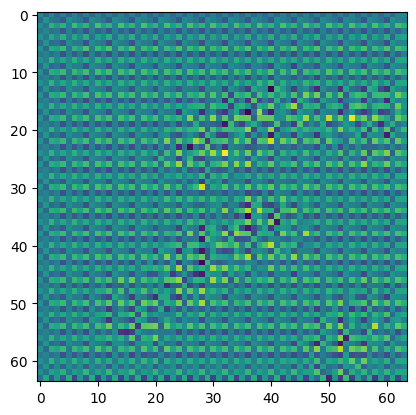

Output Shape: torch.Size([1, 64, 64, 4])
GT Heatmap Shape: torch.Size([1, 64, 64, 1])
GT Dense Shape: torch.Size([1, 64, 64, 3])


In [5]:
### new Loss funcction

def dense_loss(output, gt_heatmap, gt_dense_data, is_free, alpha=0.7, decay=1): #알파로 가중치 조절(위치와 속도 yaw에 비중 설정)
    print(f'Output Shape: {output.shape}')
    print(f'GT Heatmap Shape: {gt_heatmap.shape}')
    print(f'GT Dense Shape: {gt_dense_data.shape}')
    # fig, ax = plt.subplots(1,3, figsize=(15,5))
    # ax[0].imshow(gt_heatmap[0])
    # ax[0].set_title('GT Heatmap')
    # ax[1].imshow(gt_dense_data[:,:,:,0].squeeze())
    # ax[1].set_title('GT Dense Data')
    # ax[2].imshow(output[0,:,:,0].squeeze().detach().numpy())


    loss = 0
    batch_size = output.shape[0]

    w = gt_heatmap # unit heatmap 정답 히트맵을 그대로 가중치로 사용 

    #output은 (1, 64, 64, 4) 형태로 되어있음
    # 64*64 픽셀 모두에 대해 loss 계산
    #output[:,:,:,0] → (B, H, W) → 예측된 heatmap 값
    #.unsqueeze(-1) → (B, H, W, 1) → 차원 맞춤
    loss += (alpha * (1+w)* (output[:,:,:,0].unsqueeze(-1) - gt_heatmap)**2).sum() #위치  
    loss += ((1-alpha) * (1+w)* (output[:,:,:,1:] - gt_dense_data)**2).sum() #vx, vy, yaw

    return loss/ batch_size

# print(f'Output Shape: {output.shape}')
plt.imshow(output[0,0].detach().numpy())
plt.show()
loss = dense_loss(output.permute(0,2,3,1), gt_heatmap.unsqueeze(0).unsqueeze(-1), dense_data.unsqueeze(0), is_free)
# print(f'Loss: {loss.item()}')

## Parameter Definition

In [6]:
use_wandb = True  # WandB 활성화
save_code = True
# Define the hyperparameters, logged in wandb

#backbone = 이미지 feature 추출 
#heatmap head = 객체의 중심점 예측하는 출력
#Dense head = 중심점 외의 정보 예측 

epochs = 15
learning_rate = 5e-4
learning_rate_hm = 0.005
learning_rate_head = 0.005
architecture = "CenterSpeed: Hourglass Deep with Sigmoid, & Dropout, BatchNorm and Head with 2 frames, lower resolution: 64x64, pixelsize 0.1"
dataset = "Transfer learning test"
optimizer = "Adam"
batch_size = 32
timer = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
run_name = "CenterSpeed_" + timer
loss_used = "CenterSpeedLossFreev2 with updated logic for free tracks on the dataset level"

#wandb configurations
config = {
    "epochs": epochs,
    "learning_rate": learning_rate,
    "architecture": architecture,
    "dataset": dataset,
    "optimizer": optimizer,
    "Loss-Function": loss_used
}
if use_wandb:
    #initialize wandb run
    run = wandb.init(project="CenterSpeedLowRes", config=config, name=run_name, save_code=save_code)#initialize wandb


# 데이터 셋 나누는 부분
# val은 학습 중간 중간 매 epoch 마다 평가
# test는 학습이 끝난 후 평가
train_size = int(len(set) * 1)  # 전체 데이터 셋 중 100%를 훈련에 사용
val_size = int(len(set) * 0)  # 0% for validation since this set is seperate!
test_size = len(set) - (train_size + val_size)  # Remaining 5% for testing

train_dataset, val_dataset, test_dataset = random_split(set, [train_size, val_size, test_size])


training_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testing_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
validation_loader = DataLoader(independent_test_set, batch_size=batch_size, shuffle= False)

print("Size of Training Set: ", len(train_dataset))
print("Size of Testing Set: ", len(test_dataset))
print("Size of Validation Set: ", len(val_dataset))

net = CenterSpeedDense(image_size=64)

optimizer = torch.optim.Adam(net.parameters(), lr= learning_rate)
print("Optimizer Initialized")

loss_fn = dense_loss
print("Loss function initialized")

Size of Training Set:  2014
Size of Testing Set:  0
Size of Validation Set:  0
Optimizer Initialized
Loss function initialized


In [7]:
def print_learning_rates(optimizer):
    for i, param_group in enumerate(optimizer.param_groups):
        print(f"Learning rate of layer {i}: {param_group['lr']}")

print_learning_rates(optimizer)

net.train()

for name, param in net.named_parameters():
    if param.requires_grad:
        print("GRAD: ", name)
    else:
        print("NO GRAD: ", name)

Learning rate of layer 0: 0.0005
GRAD:  conv1.weight
GRAD:  conv1.bias
GRAD:  bn1.weight
GRAD:  bn1.bias
GRAD:  conv2.weight
GRAD:  conv2.bias
GRAD:  bn2.weight
GRAD:  bn2.bias
GRAD:  deconv1.weight
GRAD:  deconv1.bias
GRAD:  deconv2.weight
GRAD:  deconv2.bias
GRAD:  bn4.weight
GRAD:  bn4.bias
GRAD:  bn3.weight
GRAD:  bn3.bias


## Training

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# from IPython.display import clear_output, display


# def train_epoch_Centerspeed_dense(training_loader, net, optimizer, loss_fn, device = 'cpu', use_wandb=False, pdf=None):
#     running_loss = 0.
#     last_loss = 0.

#     plt.ion()
#     fig, ax = plt.subplots(1,3, figsize=(15,5))

#     for i, data in enumerate(training_loader):
#         # Every data instance is an input + label pair
#         inputs, gts, data, dense_data, is_free = data
#         inputs = inputs.to(device)
#         gts = gts.to(device)
#         data = data.to(device)
#         # Zero your gradients for every batch!
#         optimizer.zero_grad()

#         # Make predictions for this batch
#         output = net(inputs)
#         # Compute the loss and its gradients

#         loss = loss_fn(output.permute(0,2,3,1), gts.unsqueeze(-1), dense_data, is_free)
#         loss.backward()

#         # Adjust learning weights
#         optimizer.step()

#         # Gather data and report
#         running_loss += loss.item()

#         last_loss = loss.item() # loss per batch

#         ##Plot the input, output and ground truth in a interactive plot
#         for a in ax:
#             a.clear()
#         ax[0].imshow(inputs[0,0])
#         ax[0].set_title('Input')
#         ax[1].imshow(output[0,0].detach().numpy())
#         ax[1].set_title('Output')
#         ax[2].imshow(gts[0])
#         ax[2].set_title('Ground Truth')
#         print(np.max(output[0,0].detach().numpy()))
#         clear_output(wait=True)
#         display(fig)


#         print('  batch {} loss: {}'.format(i + 1, last_loss))
#         if use_wandb:
#             wandb.log({"batch_loss": last_loss/len(inputs)})#log the average loss per batch

#     plt.show()
#     return last_loss


In [9]:
from IPython.display import clear_output, display

def train_epoch_Centerspeed_dense(training_loader, net, optimizer, loss_fn, device = 'cpu', use_wandb=True, pdf=None):
    running_loss = 0.
    last_loss = 0.
    heatmap_loss_total = 0.
    dense_loss_total = 0.
    
    plt.ion()
    fig, ax = plt.subplots(1,3, figsize=(15,5))

    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, gts, data, dense_data, is_free = data
        inputs = inputs.to(device)
        gts = gts.to(device)
        data = data.to(device)
        dense_data = dense_data.to(device)  # 이 줄 추가!
        is_free = is_free.to(device)        # 이 줄도 추가!
        
        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        output = net(inputs)
        
        # 개별 손실 계산 (모니터링용)
        alpha = 0.7
        w = gts.unsqueeze(-1)
        
        # 히트맵 손실과 dense 손실 분리 계산
        heatmap_loss = (alpha * (1+w) * (output.permute(0,2,3,1)[:,:,:,0].unsqueeze(-1) - gts.unsqueeze(-1))**2).mean()
        dense_loss_val = ((1-alpha) * (1+w) * (output.permute(0,2,3,1)[:,:,:,1:] - dense_data)**2).mean()
        
        # 전체 손실 계산
        loss = loss_fn(output.permute(0,2,3,1), gts.unsqueeze(-1), dense_data, is_free)
        loss.backward()

        # 그래디언트 노름 계산
        total_norm = 0
        for p in net.parameters():
            if p.grad is not None:
                param_norm = p.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
        total_norm = total_norm ** (1. / 2)

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        heatmap_loss_total += heatmap_loss.item()
        dense_loss_total += dense_loss_val.item()
        last_loss = loss.item() # loss per batch

        ##Plot the input, output and ground truth in a interactive plot
        for a in ax:
            a.clear()
        ax[0].imshow(inputs[0,0].cpu())  # CPU로 이동해서 시각화
        ax[0].set_title('Input')
        ax[1].imshow(output[0,0].detach().cpu().numpy())  # CPU로 이동
        ax[1].set_title('Output')
        ax[2].imshow(gts[0].cpu())  # CPU로 이동
        ax[2].set_title('Ground Truth')
        
        output_max = np.max(output[0,0].detach().cpu().numpy())
        print(f'Batch {i+1}: Loss={last_loss:.4f}, Heatmap={heatmap_loss.item():.4f}, Dense={dense_loss_val.item():.4f}, Output_Max={output_max:.4f}')
        
        clear_output(wait=True)
        display(fig)

        if use_wandb:
            # 더 자세한 메트릭 로깅
            wandb.log({
                "batch_loss": last_loss,
                "batch_loss_per_sample": last_loss/len(inputs),
                "heatmap_loss": heatmap_loss.item(),
                "dense_loss": dense_loss_val.item(),
                "loss_ratio_heatmap_to_dense": heatmap_loss.item() / (dense_loss_val.item() + 1e-8),
                "gradient_norm": total_norm,
                "learning_rate": optimizer.param_groups[0]['lr'],
                "output_max_value": output_max,
                "output_mean_value": np.mean(output[0,0].detach().cpu().numpy()),
                "batch_number": i,
                "samples_processed": (i + 1) * len(inputs)
            })

    plt.show()
    
    # 에포크 평균 계산
    avg_loss = running_loss / len(training_loader)
    avg_heatmap_loss = heatmap_loss_total / len(training_loader)
    avg_dense_loss = dense_loss_total / len(training_loader)
    
    return avg_loss, avg_heatmap_loss, avg_dense_loss

In [10]:
def validate_epoch_Centerspeed_dense(validation_loader, net, loss_fn, device='cpu'):
    """
    Validation 함수 - 매 에포크마다 검증 데이터셋으로 모델 성능 평가
    """
    net.eval()  # 평가 모드로 전환 (dropout, batchnorm 비활성화)
    
    running_loss = 0.0
    heatmap_loss_total = 0.0
    dense_loss_total = 0.0
    total_samples = 0
    
    with torch.no_grad():  # 그래디언트 계산 비활성화 (메모리 절약 & 속도 향상)
        for i, data in enumerate(validation_loader):
            inputs, gts, data_batch, dense_data, is_free = data
            
            # 모든 텐서를 동일한 디바이스로 이동
            inputs = inputs.to(device)
            gts = gts.to(device)
            data_batch = data_batch.to(device)
            dense_data = dense_data.to(device)
            is_free = is_free.to(device)
            
            # 예측 수행
            output = net(inputs)
            
            # 개별 손실 계산
            alpha = 0.7
            w = gts.unsqueeze(-1)
            
            heatmap_loss = (alpha * (1+w) * (output.permute(0,2,3,1)[:,:,:,0].unsqueeze(-1) - gts.unsqueeze(-1))**2).mean()
            dense_loss_val = ((1-alpha) * (1+w) * (output.permute(0,2,3,1)[:,:,:,1:] - dense_data)**2).mean()
            
            # 전체 손실 계산
            loss = loss_fn(output.permute(0,2,3,1), gts.unsqueeze(-1), dense_data, is_free)
            
            # 통계 누적
            running_loss += loss.item()
            heatmap_loss_total += heatmap_loss.item()
            dense_loss_total += dense_loss_val.item()
            total_samples += len(inputs)
    
    # 평균 계산
    avg_val_loss = running_loss / len(validation_loader)
    avg_val_heatmap_loss = heatmap_loss_total / len(validation_loader)
    avg_val_dense_loss = dense_loss_total / len(validation_loader)
    
    net.train()  # 다시 훈련 모드로 전환
    
    return avg_val_loss, avg_val_heatmap_loss, avg_val_dense_loss, total_samples

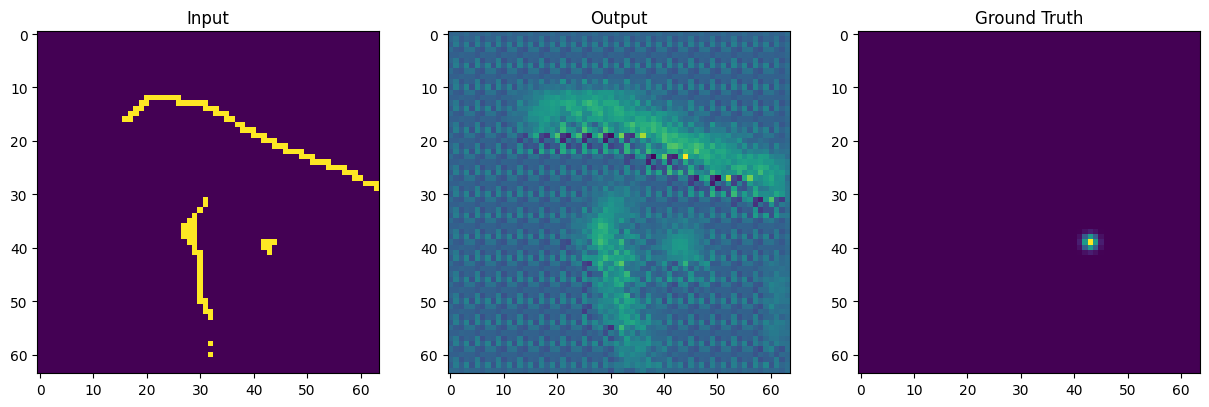

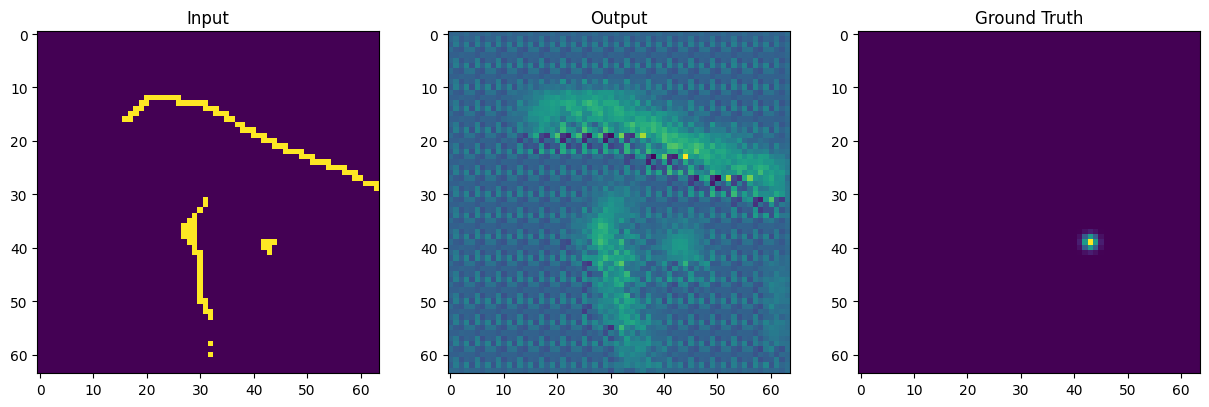

Epoch 0 completed!
Average Loss: 6344.6041
Heatmap Loss: 0.6776
Dense Loss: 0.2904
Learning Rate: 0.000500
Model saved at epoch 0


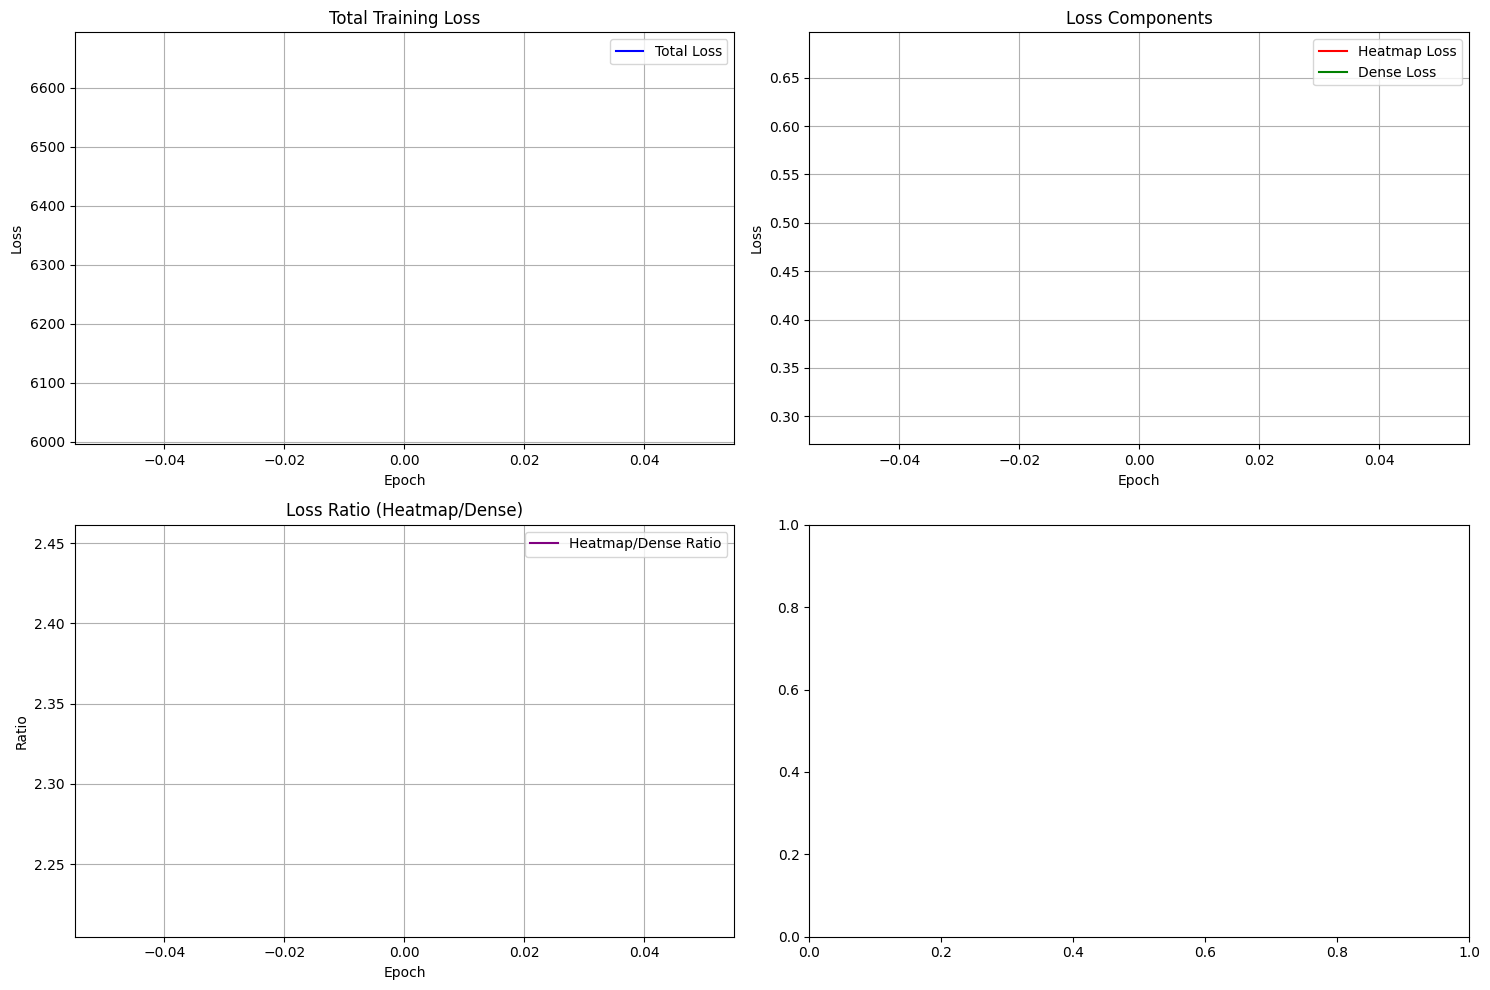


=== Training Summary ===
Initial Loss: 6344.6041
Final Loss: 6344.6041
Total Improvement: 0.00%


In [11]:
# Initializing in a separate cell so we can easily add more epochs to the same run
#net, optimizer, loss_fn, training_loader, validation_loader = initialize(config)
net.to(device)

# EPOCHS = 10000
EPOCHS = 1
losses = []
heatmap_losses = []
dense_losses = []

for epoch in range(EPOCHS):
    print(f'Epoch: {epoch}')
    net.train()
    
    # 학습률 스케줄링 (옵션)
    if epoch > 0 and epoch % 5 == 0:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.9  # 5 에포크마다 학습률 10% 감소
    
    # 학습 실행
    avg_loss, avg_heatmap_loss, avg_dense_loss = train_epoch_Centerspeed_dense(
        training_loader=training_loader, 
        net=net, 
        optimizer=optimizer,
        loss_fn=loss_fn, 
        device=device, 
        use_wandb=True
    )

    losses.append(avg_loss)
    heatmap_losses.append(avg_heatmap_loss)
    dense_losses.append(avg_dense_loss)

    # WandB에 에포크 단위 메트릭 로깅
    if use_wandb:
        # 모델 가중치 통계
        weight_stats = {}
        for name, param in net.named_parameters():
            if param.requires_grad:
                weight_stats[f"weights/{name}_mean"] = param.data.mean().item()
                weight_stats[f"weights/{name}_std"] = param.data.std().item()
                weight_stats[f"weights/{name}_max"] = param.data.max().item()
                weight_stats[f"weights/{name}_min"] = param.data.min().item()
        
        # 종합 메트릭 로깅
        wandb.log({
            "epoch": epoch,
            "epoch_loss": avg_loss,
            "epoch_heatmap_loss": avg_heatmap_loss,
            "epoch_dense_loss": avg_dense_loss,
            "epoch_loss_improvement": (losses[0] - avg_loss) / losses[0] if len(losses) > 1 else 0,
            "current_learning_rate": optimizer.param_groups[0]['lr'],
            **weight_stats
        })

    print(f'Epoch {epoch} completed!')
    print(f'Average Loss: {avg_loss:.4f}')
    print(f'Heatmap Loss: {avg_heatmap_loss:.4f}')
    print(f'Dense Loss: {avg_dense_loss:.4f}')
    print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')

    # save the model every epoch - 로컬 경로로 변경
    if epoch % 1 == 0:
        model_path = f'./trained_models/epoch_{epoch}.pt'
        torch.save(net.state_dict(), model_path)
        if use_wandb:
            wandb.save(model_path)
        print(f"Model saved at epoch {epoch}")

# 최종 차트 생성
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 전체 손실
axes[0,0].plot(losses, 'b-', label='Total Loss')
axes[0,0].set_title('Total Training Loss')
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('Loss')
axes[0,0].legend()
axes[0,0].grid(True)

# 히트맵 vs Dense 손실
axes[0,1].plot(heatmap_losses, 'r-', label='Heatmap Loss')
axes[0,1].plot(dense_losses, 'g-', label='Dense Loss')
axes[0,1].set_title('Loss Components')
axes[0,1].set_xlabel('Epoch')
axes[0,1].set_ylabel('Loss')
axes[0,1].legend()
axes[0,1].grid(True)

# 손실 비율
if len(heatmap_losses) > 0 and len(dense_losses) > 0:
    loss_ratios = [h/(d+1e-8) for h, d in zip(heatmap_losses, dense_losses)]
    axes[1,0].plot(loss_ratios, 'purple', label='Heatmap/Dense Ratio')
    axes[1,0].set_title('Loss Ratio (Heatmap/Dense)')
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].set_ylabel('Ratio')
    axes[1,0].legend()
    axes[1,0].grid(True)

# 손실 개선률
if len(losses) > 1:
    improvements = [(losses[0] - loss) / losses[0] * 100 for loss in losses]
    axes[1,1].plot(improvements, 'orange', label='Loss Improvement %')
    axes[1,1].set_title('Training Progress (%)')
    axes[1,1].set_xlabel('Epoch')
    axes[1,1].set_ylabel('Improvement (%)')
    axes[1,1].legend()
    axes[1,1].grid(True)

plt.tight_layout()
plt.show()

print(f"\n=== Training Summary ===")
print(f"Initial Loss: {losses[0]:.4f}")
print(f"Final Loss: {losses[-1]:.4f}")
print(f"Total Improvement: {((losses[0] - losses[-1]) / losses[0] * 100):.2f}%")

In [12]:
for name, param in net.named_parameters():
    if param.grad is None:
        print(name, param.data)
    if param.grad is not None:
        print(name)



conv1.weight
conv1.bias
bn1.weight
bn1.bias
conv2.weight
conv2.bias
bn2.weight
bn2.bias
deconv1.weight
deconv1.bias
deconv2.weight
deconv2.bias
bn4.weight
bn4.bias
bn3.weight
bn3.bias


In [ ]:
input = next(iter(training_loader))[0]
input = input.to(device)  # GPU로 이동 추가!

#모델 추론 성능
import time
start = time.perf_counter()
output = net(input)
end = time.perf_counter()

print(f'Elapsed time: {(end-start)*1000} ms')
print(f'Input Shape: {input.shape}')
print(f'Output Shape: {output.shape}')

input, gt_heatmap, data, dense_data, is_free = set[100]
input = input.unsqueeze(0).to(device)  # GPU로 이동 추가!
output = net(input)

Using dense features with data: tensor([ 0.9797,  0.6984,  0.2047, -0.4760,  1.1648])
Data length: 5
Using dense features with data: tensor([ 1.0067,  0.5417,  0.7891, -1.1835,  0.9827])
Data length: 5
Using dense features with data: tensor([ 1.3164,  0.5997,  1.4526, -1.0602,  0.6305])
Data length: 5
Using dense features with data: tensor([ 1.1686,  0.7287,  1.0692, -1.4408,  0.9324])
Data length: 5
Using dense features with data: tensor([ 1.0464,  0.5524,  1.0822, -0.9968,  0.7443])
Data length: 5
Using dense features with data: tensor([ 1.3698,  0.4254,  2.2320, -1.6376,  0.6330])
Data length: 5
Using dense features with data: tensor([ 1.0456,  0.6907,  0.5549, -1.1296,  1.1141])
Data length: 5
Using dense features with data: tensor([ 1.2437,  0.5423,  1.1313, -1.1505,  0.7938])
Data length: 5
Using dense features with data: tensor([ 0.3729,  0.5442,  1.5333, -1.3503,  0.7220])
Data length: 5
Using dense features with data: tensor([ 0.6234,  0.7472,  2.0510, -1.5215,  0.6383])
Data 

In [15]:

print(output.shape)

torch.Size([1, 4, 64, 64])


Using dense features with data: tensor([ 1.0194,  1.0358,  0.6196, -2.5490,  1.3323])
Data length: 5


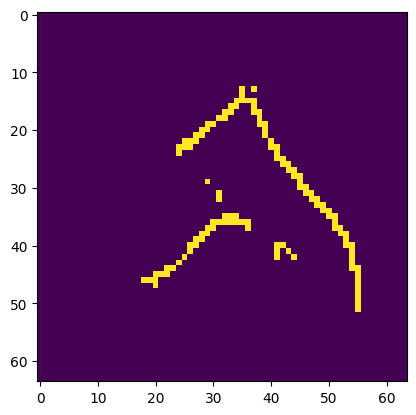

tensor([ 1.0194,  1.0358,  0.6196, -2.5490,  1.3323])


/tmp/ipykernel_61198/1724336391.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output[0,0] = F.softmax(output[0,0])


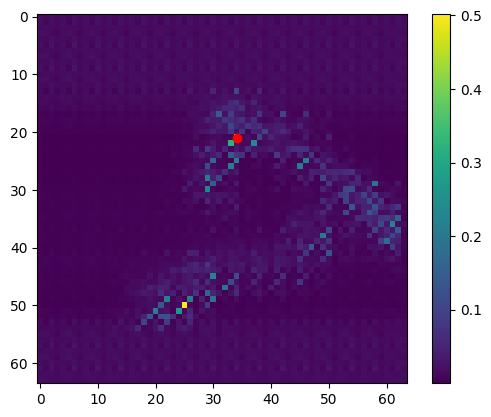

Output: Heatmap


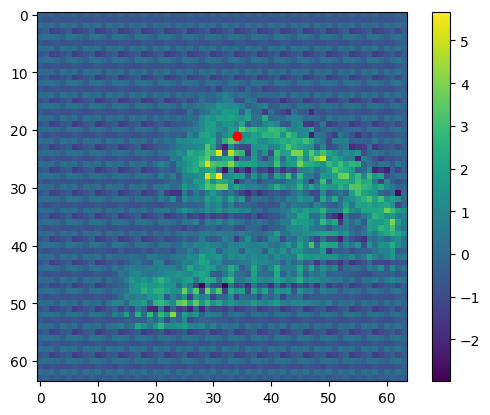

GT: 0.6196096539497375 
Output: -1.17953360080719 
Maximum value in image slice 1: 5.672033786773682
Minimum value in image slice 1: -2.9811325073242188


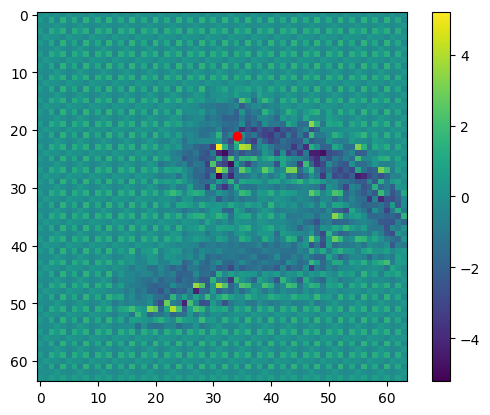

GT: -2.548961877822876 
Output: -1.622305154800415 
Maximum value in image slice 2: 5.217662334442139
Minimum value in image slice 2: -5.2171125411987305


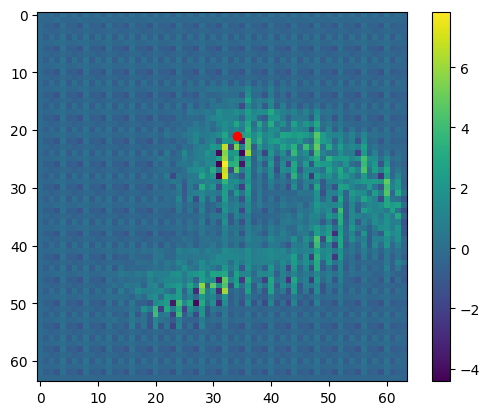

GT: 1.3323382139205933 
Output: 2.9952242374420166 
Maximum value in image slice 3: 7.842099666595459
Minimum value in image slice 3: -4.4191789627075195


In [16]:
input, gt_heatmap, data, dense_data, is_free = set[np.random.randint(0, len(set))]
input = input.unsqueeze(0).to(device)  # GPU로 이동 추가!

plt.imshow(input[0,0].cpu())  # 시각화를 위해 CPU로 이동
plt.show()
max_index = np.unravel_index(output[0,0].detach().cpu().numpy().argmax(), output[0,0].shape)
output[0,0] = F.softmax(output[0,0])
print(data)
for i in range(output.shape[1]):
    plt.imshow(output[0,i].detach().cpu().numpy())
    plt.plot(max_index[1], max_index[0], 'ro')
    plt.colorbar()
    plt.show()
    if i == 0:
        print(f'Output: Heatmap')
        continue

    value_at_max = output[0,i].detach().cpu().numpy()[max_index]
    max_value = np.max(output[0,i].detach().cpu().numpy())
    min_value = np.min(output[0,i].detach().cpu().numpy())

    print(f'GT: {data[1+i]} ')
    print(f'Output: {value_at_max} ')
    print(f'Maximum value in image slice {i}: {max_value}')
    print(f'Minimum value in image slice {i}: {min_value}')
